## Model Training and Evaluation

In this step, we train multiple machine learning classification models
to detect fraudulent credit card transactions and evaluate them using
appropriate performance metrics.


In [20]:
import sys
sys.path.append('../src')

from loader import load_data
from preprocessing import (
    split_features_target,
    scale_amount,
    stratified_split,
    apply_smote
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve
)

from xgboost import XGBClassifier


## Data Loading and Preprocessing

In this step, the dataset is loaded and prepared for model training.
This includes feature–target separation, scaling of transaction amounts,
stratified train–test splitting, and handling class imbalance.


In [21]:
df = load_data('../data/creditcard.csv')

# Split features and target
X, y = split_features_target(df)

# Scale transaction amount
X_scaled, scaler = scale_amount(X)

# Stratified train-test split
X_train, X_test, y_train, y_test = stratified_split(X_scaled, y)


## Baseline Model: Logistic Regression

Logistic Regression is used as a simple and interpretable baseline.
Class-weighted learning is applied to handle severe class imbalance
without oversampling.


In [22]:
lr_model = LogisticRegression(
    max_iter=2000,
    solver='liblinear',
    class_weight='balanced'
)

lr_model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [23]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

lr_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])
print("Logistic Regression ROC-AUC:", lr_auc)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Logistic Regression ROC-AUC: 0.9721389487843535


## Comparison Model: Random Forest

Random Forest is used as a non-linear baseline to compare against
Logistic Regression and the final XGBoost model. SMOTE is applied
only on the training data to handle class imbalance for tree-based models.


In [24]:
from sklearn.ensemble import RandomForestClassifier

# Apply SMOTE only for Random Forest comparison
X_train_smote, y_train_smote = apply_smote(X_train, y_train)

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_smote, y_train_smote)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

Random Forest captures non-linear relationships in the data and generally
improves precision compared to linear models, making it suitable for
fraud detection tasks.


In [27]:
# Predict class labels and probabilities
y_pred_rf = rf_model.predict(X_test)
y_probs = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

rf_auc = roc_auc_score(y_test, y_probs)
print("Random Forest ROC-AUC:", rf_auc)


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.82      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Random Forest ROC-AUC: 0.9832547115638602


## Final Model: XGBoost (Cost-Sensitive Learning)

XGBoost is used as the final model due to its strong performance on imbalanced
classification problems. Cost-sensitive learning via `scale_pos_weight`
is applied instead of oversampling.


In [29]:
# Final XGBoost model with cost-sensitive learning
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)


,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.8
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_metho

In [30]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
print("XGBoost ROC-AUC:", xgb_auc)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

XGBoost ROC-AUC: 0.9814069444603953


ROC Curve

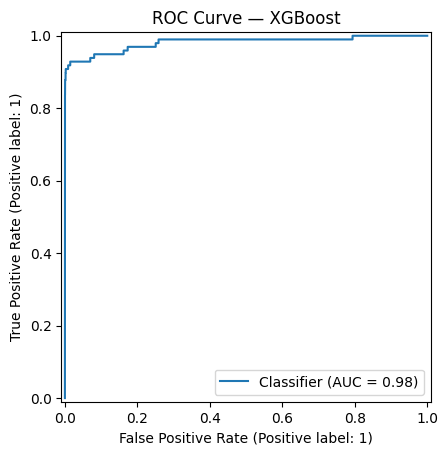

In [31]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_test,
    xgb_probs
)
plt.title("ROC Curve — XGBoost")
plt.show()


## Threshold Optimization for XGBoost

Instead of using the default 0.5 threshold, different probability thresholds
are evaluated to balance fraud recall and precision based on business needs.


In [32]:
# Get predicted probabilities for the positive (fraud) class
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]


### Evaluating Different Decision Thresholds

Multiple probability thresholds are evaluated to observe the trade-off
between fraud recall and precision. This helps select an operating point
aligned with business requirements.


In [33]:
import numpy as np
from sklearn.metrics import classification_report

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]

for t in thresholds:
    print(f"\nThreshold: {t}")
    y_pred_t = (xgb_probs >= t).astype(int)
    print(classification_report(y_test, y_pred_t))



Threshold: 0.2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.86      0.81        98

    accuracy                           1.00     56962
   macro avg       0.88      0.93      0.90     56962
weighted avg       1.00      1.00      1.00     56962


Threshold: 0.3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.84      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962


Threshold: 0.4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00   

### Selecting the Optimal Threshold

Based on the evaluation results, a threshold is selected that provides
high fraud recall while maintaining acceptable precision. This reflects
a real-world fraud detection trade-off.


Final XGBoost Classification Report (Threshold = 0.3)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.84      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962



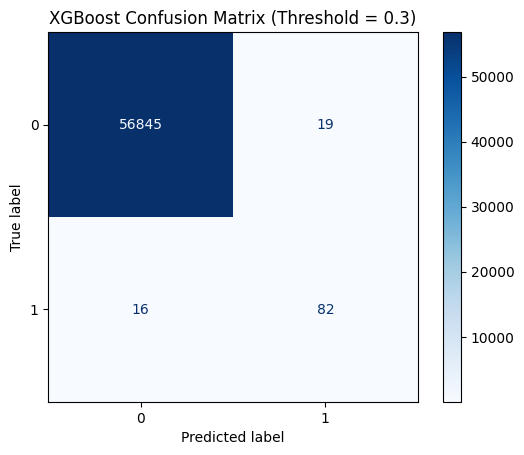

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Selected threshold based on business trade-off
BEST_THRESHOLD = 0.3

y_pred_final = (xgb_probs >= BEST_THRESHOLD).astype(int)

print(f"Final XGBoost Classification Report (Threshold = {BEST_THRESHOLD})")
print(classification_report(y_test, y_pred_final))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_final,
    cmap="Blues",
    values_format="d"
)

plt.title(f"XGBoost Confusion Matrix (Threshold = {BEST_THRESHOLD})")
plt.show()


In [35]:
BEST_THRESHOLD = 0.3


In [36]:
joblib.dump(
    {"model": xgb_model, "threshold": BEST_THRESHOLD},
    "../models/xgboost_fraud_bundle.pkl"
)


['../models/xgboost_fraud_bundle.pkl']

## Model Explainability using SHAP

SHAP (SHapley Additive exPlanations) is used to interpret the XGBoost model.
It explains how individual features contribute to fraud predictions,
helping improve transparency and trust in the model.


In [37]:
import shap


### Creating SHAP Explainer and Computing SHAP Values

A SHAP explainer is created for the trained XGBoost model to compute
feature contributions for model predictions.


In [38]:
# Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for a sample of test data (for efficiency)
X_test_sample = X_test.sample(1000, random_state=42)
shap_values = explainer.shap_values(X_test_sample)


### Global Feature Importance (SHAP Summary Plot)

The SHAP summary plot shows the overall impact of features on the model's
predictions across multiple transactions. Features are ranked by their
importance in detecting fraud.


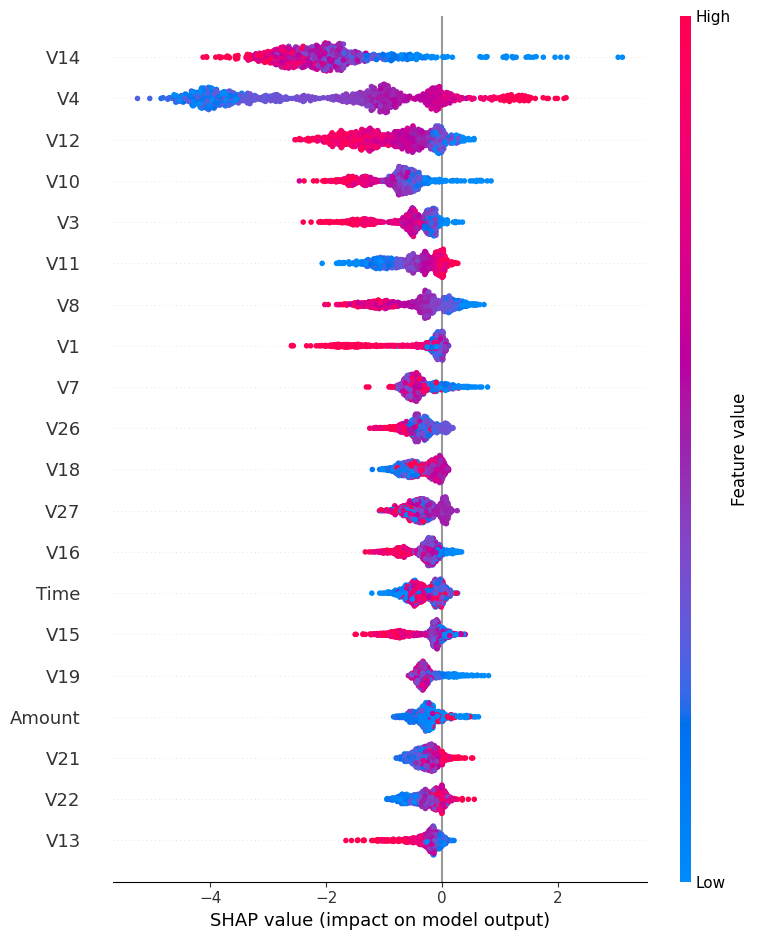

In [39]:
# Global feature importance using SHAP summary plot
shap.summary_plot(shap_values, X_test_sample)


### Local Explanation for a Single Transaction

This visualization explains why the model predicted a specific transaction
as fraudulent by showing feature-level contributions to the final decision.


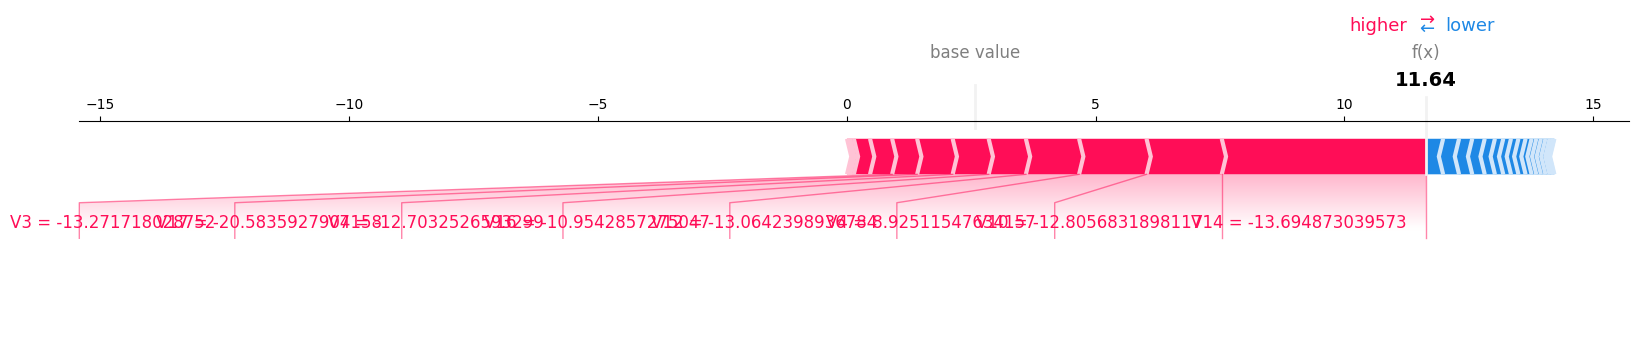

In [40]:
# Select a transaction with high predicted fraud probability
sample_index = xgb_probs.argsort()[-1]  # most suspicious transaction

# Explain the prediction for this transaction
shap.force_plot(
    explainer.expected_value,
    explainer.shap_values(X_test.iloc[[sample_index]]),
    X_test.iloc[[sample_index]],
    matplotlib=True
)


## Saving the Final Model for Deployment

The trained XGBoost model and the selected decision threshold are saved
together to ensure consistent behavior during deployment and inference.


In [41]:
import joblib

joblib.dump(
    {
        "model": xgb_model,
        "threshold": BEST_THRESHOLD
    },
    "../models/xgboost_fraud_bundle.pkl"
)

print("Final XGBoost model and threshold saved successfully")


Final XGBoost model and threshold saved successfully


## Notebook Summary

This notebook covered the complete model training workflow for credit card
fraud detection, including baseline comparisons, final XGBoost modeling,
threshold optimization, and model explainability using SHAP. The finalized
model and decision threshold were saved for deployment and future inference.
